In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from pandas import read_csv
import os
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
np.random.seed(1)
tf.compat.v1.disable_v2_behavior() 
sns.set_theme(style="whitegrid")
if os.name == 'posix':
    plt.rc('font', family='AppleGothic')
elif os.name == 'nt':
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import shap
import warnings
import time



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#seoul_pow
#pusan_pow
#jeju_pow
#kor_dust -> 종로
#kangil_dust
#kangdong_dust
#incheon_dust


DATA_NAME = 'pusan_pow'
MODEL_NAME = str(int(time.time()))
CLASSFICATION_EPOCH = 200
EPOCH = 200
FULLYCON = False
OTHER_FLAG = True

dataset = read_csv('./data/'+DATA_NAME+'.csv')
#dataset=dataset[:365*24]
dataset_day = read_csv('./data/'+DATA_NAME+'_day.csv')
#dataset_day=dataset_day[:365]
print('Data Cols / ',dataset.columns)

Data Cols /  Index(['Unnamed: 0', '연료원', '지역세부구분', '거래일', '시간', '전력거래량', 'YMDH', 'month',
       'fullday', 'season', 'year', '지점', '지점명', '기온(°C)', '강수량(mm)',
       '강수량 QC플래그', '풍속(m/s)', '풍향(16방위)', '습도(%)', '증기압(hPa)', '이슬점온도(°C)',
       '현지기압(hPa)', '해면기압(hPa)', '일조(hr)', '일사(MJ/m2)', '적설(cm)', '3시간신적설(cm)',
       '전운량(10분위)', '중하층운량(10분위)', '운형(운형약어)', '최저운고(100m )', '시정(10m)',
       '지면상태(지면상태코드)', '현상번호(국내식)', '지면온도(°C)', '5cm 지중온도(°C)',
       '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)'],
      dtype='object')


In [3]:
Features = ['지면온도(°C)']
Target = '전력거래량'

           지면온도(°C)       fullday          YMDH
count  57696.000000  5.769600e+04  5.769600e+04
mean      16.917138  2.016874e+07  2.016874e+09
std       11.524051  1.906177e+04  1.906177e+06
min      -10.000000  2.014010e+07  2.014010e+09
25%        8.100000  2.015082e+07  2.015082e+09
50%       17.100000  2.017042e+07  2.017042e+09
75%       24.200000  2.018121e+07  2.018121e+09
max       66.300000  2.020073e+07  2.020073e+09


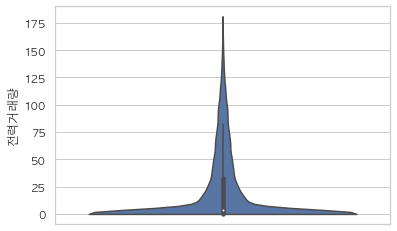

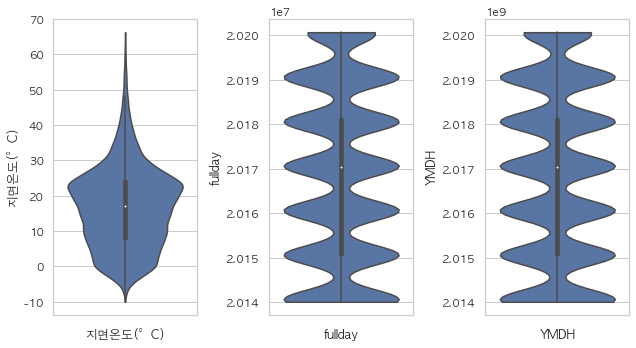

,지면온도(°C),fullday,YMDH
지면온도(°C),1.000000,0.016791,0.016792
fullday,0.016791,1.000000,1.000000
YMDH,0.016792,1.000000,1.000000


In [4]:


#Features = ['SO2', 'CO', 'O3','NO2', 'PM10', 'PM25']
#Target = 'PM25'

Features.append('fullday')
Features.append('YMDH')

print(dataset[Features].describe())

DF=dataset


TEST=DF[Features]

Target_LIST = DF[Target].to_list()

sns.violinplot(y=DF[Target],cut=0)


'''
SCALED_Y = DF[[Target]].values.astype(float)
Y_min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
Target_LIST = Y_min_max_scaler.fit_transform(Target_LIST)
Target_LIST = list(Target_LIST)
'''


fig = plt.figure(figsize=(3*len(Features),5))
gs = fig.add_gridspec(1, len(Features))

for i in range(len(Features)):
    ax = fig.add_subplot(gs[0, i])
    sns.violinplot(y=TEST[Features[i]],cut=0)
    ax.set_xlabel(Features[i])

fig.tight_layout()
plt.show()

TEST.corr()

In [5]:


#['기온(°C)','습도(%)','전력거래량','강수량(mm)','풍속(m/s)','일조(hr)','일사(MJ/m2)']
#이하, 초과 [MAX, MIN]

#    '0': {
#        '기온(°C)': [[1.00, .75]],'강수량(mm)': [[1.00, .75]]
#    }, 
#['SO2', 'CO', 'O3','NO2', 'PM10', 'PM25']
'''
FeaturesRange = {
    '0': {
        'PM10': [[1.00, 0.25]]
    }, 
    '1': {
        'PM10': [[0.25, 0.20]]
    } 
}

FeaturesRange = {
    '0': {
        'Ground temperature': [[1.0, 0.75]]
    },
    '1': {
        'Ground temperature': [[0.75, 0.5]]
    },
    '2': {
        'Ground temperature': [[0.5, 0.25]]
    },
    '3': {
        'Ground temperature': [[0.25, -0.01]]
    }
}

FeaturesRange = {
    '0': {
        '일사(MJ/m2)': [[1.00, 0.50]]
    },
    '1': {
        '일사(MJ/m2)': [[0.50, 0.10]]
    },
    '2': {
        '일사(MJ/m2)': [[0.10, -0.01]]
    }
}

'''
FeaturesRange = {
    '0': {
        '지면온도(°C)': [[1.00, 0.50]]
    },
    '1': {
        '지면온도(°C)': [[0.50, -0.01]]
    }
}



In [6]:

def GetSubSets(_DF,_dataset_day,FeaturesRange):
    
    full_df = _DF
    full_df['Group'] = 'Other'

    day_df = _dataset_day
    LAST_DAY = full_df[-2:-1]
    LAST_DAY = int(LAST_DAY['fullday'])
    CAP_DAY =[]
    print(LAST_DAY)
    

    #print(FeaturesRange)
    #{'0': {'temprt': [[80, 70]], 'rain': [[90, 78.2]], 'wnd_spd': [[100, 90]], 'humdt': [[80, 70]], 'cloud': [[100, 90]]}, '1': {'rain': [[100, 90]]}, '2': {'temprt': [[90, 80]], 'humdt': [[90, 80]]}, '3': {'temprt': [[100, 90]], 'humdt': [[100, 90]]}}
    #del FeaturesRange['0']
    
    res_GDF = []
    GroupDF = {}
    for Groups in FeaturesRange:
        TMP = FeaturesRange[Groups]
        GroupDF[Groups] = day_df
        for Feature in TMP:
            Filters = TMP[Feature]
            F_MAX = day_df[Feature].max()
            F_MIN = day_df[Feature].min()
            ABSRange = abs(F_MIN-F_MAX)
            for MAX,MIN in Filters:
                MAX=ABSRange*MAX
                MIN=ABSRange*MIN
                MAX = MAX+F_MIN
                MIN = MIN+F_MIN
                GroupDF[Groups] = GroupDF[Groups].loc[(GroupDF[Groups][Feature] > MIN) & (GroupDF[Groups][Feature] <= MAX)]

    for Groups in GroupDF:
        list_of_day = GroupDF[Groups]['fullday'].tolist()
        TMP_DATAFRAME = pd.DataFrame()
        CAP_DAY+=list_of_day
        if LAST_DAY in list_of_day:
            list_of_day.remove(LAST_DAY)
        
        for i in list_of_day:
            tmp_ST = full_df.loc[full_df['fullday']==i].index[0]
            TMP_DF = pd.DataFrame(full_df[tmp_ST:tmp_ST+24])
            TMP_DF.reset_index(inplace=True, drop=True)
            TMP_DF.insert(loc=0, column='TARGET', value=Target_LIST[tmp_ST+24:tmp_ST+48])
            
            TMP_DATAFRAME = pd.concat([TMP_DATAFRAME,TMP_DF],ignore_index=True)
            
        TMP_DATAFRAME['Group'] = Groups
        TMP_DATAFRAME.sort_values("YMDH", ascending=True)
        res_GDF.append(TMP_DATAFRAME)
        
    full_df = full_df.shift(24)
    full_df.insert(loc=0, column='TARGET', value=Target_LIST)
    
    full_df = full_df.drop(full_df.loc[full_df['fullday'].isin(CAP_DAY)].index, errors='ignore')
    
    full_df=full_df.dropna(axis=0)

    full_df = full_df.sort_values("YMDH", ascending=True)
    full_df.reset_index(inplace=True, drop=True)
    full_df['fullday'] = full_df['fullday'].astype(int)
    if not full_df.empty:
        res_GDF.append(full_df)
    else:
        print('OTHER_FLAG')
        OTHER_FLAG=False
    return res_GDF


In [7]:
RES_TEST = GetSubSets(TEST,dataset_day,FeaturesRange)
for Q in RES_TEST:
    print(Q.groupby('Group').count())


if len(RES_TEST)==len(FeaturesRange):
    OTHER_FLAG = False 

print(OTHER_FLAG)

Features.remove('fullday')
Features.remove('YMDH')



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


20200731
OTHER_FLAG
       TARGET  지면온도(°C)  fullday   YMDH
Group                                  
0       27960     27960    27960  27960
       TARGET  지면온도(°C)  fullday   YMDH
Group                                  
1       29712     29712    29712  29712
False


In [8]:

#'MINMAX'
#'STD'
#'YEO'
# ''
SCALE_FUNC = 'MINMAX'

def SCALE_FUCTIONS(_DF):
    TMP_TARGET = _DF['TARGET'].to_list()
    
    _DF=_DF[Features]
    if SCALE_FUNC == 'MINMAX':
        _DF = MINMAX_scaler.transform(_DF)
    elif SCALE_FUNC == 'STD':
        _DF = STD_scaler.transform(_DF.values)
    elif SCALE_FUNC == 'YEO':
        _DF = YEO_scaler.transform(_DF)
    else:
        _DF = _DF
    
    _DF = pd.DataFrame(_DF,columns=Features)
    _DF.insert(loc=0, column='TARGET', value=TMP_TARGET)
    return _DF
    
MINMAX_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
STD_scaler = preprocessing.StandardScaler()
YEO_scaler = preprocessing.PowerTransformer(method='yeo-johnson')

TEST = DF[Features]
MINMAX_scaler.fit(TEST)
STD_scaler.fit(TEST)
YEO_scaler.fit(TEST)


ALL_X=DF[Features]
print(ALL_X)
ALL_X = ALL_X.shift(24)
ALL_X.insert(loc=0, column='TARGET', value=Target_LIST)
ALL_X=ALL_X.dropna(axis=0)
ALL_X.reset_index(inplace=True, drop=True)
ALL_X = SCALE_FUCTIONS(ALL_X)


for i in range(len(RES_TEST)):
    RES_TEST[i] = SCALE_FUCTIONS(RES_TEST[i])
    

       지면온도(°C)
0           2.4
1           2.2
2           1.8
3           1.4
4           1.2
...         ...
57691      26.8
57692      26.2
57693      25.8
57694      25.5
57695      23.7

[57696 rows x 1 columns]


In [9]:
G_TRAIN_X = []
G_TRAIN_y = []

G_TEST_X = []
G_TEST_y = []

G_DISPLAY_Y = []
G_DISPLAY_TEST_Y = []
MIN_Y=float("inf")
MAX_Y=-1
for G in RES_TEST:
    values = G.values
    Xdata = values[:, 1:]
    Xdata = Xdata.reshape((int(Xdata.shape[0]/24),24,len(Features)))
    
    G_TRAIN_X.append(Xdata[:int(Xdata.shape[0]*0.8)])
    G_TEST_X.append(Xdata[int(Xdata.shape[0]*0.8):])
    
    Ydata = values[:, 0]
    Ydata = Ydata.reshape((int(len(Ydata)/24),24))
    
    Ydata = Ydata.sum(axis=1)
    Ydata = list(Ydata.reshape((Ydata.shape[0],)))
    if MIN_Y>min(Ydata):
        MIN_Y = min(Ydata)
    if MAX_Y<max(Ydata):
        MAX_Y = max(Ydata)
    
    G_DISPLAY_Y = G_DISPLAY_Y+Ydata[:int(len(Ydata)*0.8)]
    G_DISPLAY_TEST_Y= G_DISPLAY_TEST_Y + Ydata[int(len(Ydata)*0.8):]
    
    if FULLYCON:
        Ydata = Ydataa.reshape((Ydata.shape[0],Ydata.shape[1],1))

    G_TRAIN_y.append(Ydata[:int(len(Ydata)*0.8)])
    G_TEST_y.append(Ydata[int(len(Ydata)*0.8):])



CLASSIFI_X = G_TRAIN_X[0]
CLASSIFI_y = [0 for _ in range(G_TRAIN_X[0].shape[0])]

CLASSIFI_TEST_X = G_TEST_X[0]
CLASSIFI_TEST_y = [0 for _ in range(G_TEST_X[0].shape[0])]

for G in range(1,len(RES_TEST)):
    CLASSIFI_X = np.concatenate((CLASSIFI_X, G_TRAIN_X[G]), axis=0)
    CLASSIFI_y = CLASSIFI_y + [G for _ in range(G_TRAIN_X[G].shape[0])]
    
    CLASSIFI_TEST_X = np.concatenate((CLASSIFI_TEST_X, G_TEST_X[G]), axis=0)
    CLASSIFI_TEST_y = CLASSIFI_TEST_y + [G for _ in range(G_TEST_X[G].shape[0])]

CLASSIFI_X = CLASSIFI_X.reshape((CLASSIFI_X.shape[0],CLASSIFI_X.shape[1]*CLASSIFI_X.shape[2]))
CLASSIFI_TEST_X = CLASSIFI_TEST_X.reshape((CLASSIFI_TEST_X.shape[0],CLASSIFI_TEST_X.shape[1]*CLASSIFI_TEST_X.shape[2]))

CLASSIFI_y = np.array(CLASSIFI_y)
CLASSIFI_y_Dis = CLASSIFI_y
CLASSIFI_y = pd.get_dummies(CLASSIFI_y)

CLASSIFI_TEST_y
CLASSIFI_TEST_y = np.array(CLASSIFI_TEST_y)
CLASSIFI_TEST_y_Dis = CLASSIFI_TEST_y
CLASSIFI_TEST_y = pd.get_dummies(CLASSIFI_TEST_y)

for i in range(len(G_TRAIN_y)):
    G_TRAIN_y[i] = [(X - MIN_Y)/(MAX_Y - MIN_Y) for X in G_TRAIN_y[i]]


In [10]:

values = ALL_X.values
Xdata = values[:, 1:]
Xdata = Xdata.reshape((int(Xdata.shape[0]/24),24,len(Features)))
    
ALL_TRAIN_X=Xdata[:int(Xdata.shape[0]*0.8)]
    
Ydata = values[:, 0]
Ydata = Ydata.reshape((int(len(Ydata)/24),24))
    
Ydata = Ydata.sum(axis=1)
Ydata = list(Ydata.reshape((Ydata.shape[0],)))

ALL_DISPLAY_Y = []

ALL_DISPLAY_Y = ALL_DISPLAY_Y+Ydata[:int(len(Ydata)*0.8)]
    
ALL_TRAIN_y = Ydata[:int(len(Ydata)*0.8)]

ALL_TRAIN_y = [(X - MIN_Y)/(MAX_Y - MIN_Y) for X in ALL_TRAIN_y]


In [11]:
#CLASSFICATION_PATH = MODEL_PATH+'/'+MODEL_NAME+'_CLASSIFICATION.h5'

import random

testlinC = []
for i in range(100):
    testlinC.append(random.randint(0, CLASSIFI_TEST_X.shape[0]-1))

enTest_X = CLASSIFI_TEST_X[testlinC, :]
enTest_y = CLASSIFI_TEST_y_Dis[testlinC]

enTest_dis_y= G_DISPLAY_TEST_Y[:]
enTest_dis_y = np.vstack(enTest_dis_y)
enTest_dis_y = enTest_dis_y[testlinC,:]

print(enTest_dis_y.shape)

print(enTest_X.shape)

(100, 1)
(100, 24)


In [ ]:
MODEL_PATH ='models/'+DATA_NAME+'/'+MODEL_NAME 
os.makedirs(MODEL_PATH, exist_ok=True)

tp = pd.DataFrame( data = {'MIN_Y': [MIN_Y],'MAX_Y': [MAX_Y] } )
tp.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_MINMAX.csv')

weights_dict = [dict() for _ in range(len(RES_TEST))]
def TEMPFUNC(TI):
    return models[TI].predict(G_TRAIN_X[TI])

def build_model(train_X, train_y ):
    M = tf.keras.Sequential()

    if FULLYCON:
        M.add(tf.keras.layers.LSTM(200,  input_shape = (train_X.shape[1], train_X.shape[2])))
        M.add(tf.keras.layers.RepeatVector(24))
        M.add(tf.keras.layers.LSTM(200,  return_sequences=True))
        M.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100, activation='relu')))
        M.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))
    else:
        M.add(tf.keras.layers.LSTM(100,  input_shape = (train_X.shape[1], train_X.shape[2])))
        M.add(tf.keras.layers.Dense(50, activation='relu'))
        M.add(tf.keras.layers.Dense(1))

    optimizer = tf.keras.optimizers.Adam()

    M.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_squared_logarithmic_error','mean_squared_error'])
    return M


#mean_absolute_error

models = []
for GN in range(len(RES_TEST)):
    models.append(build_model(G_TRAIN_X[GN],G_TRAIN_y[GN]))
        # Open the file
    with open(MODEL_PATH + '/'+str(GN)+'_summary.txt','w') as fh:
        models[GN].summary(print_fn=lambda x: fh.write(x + '\n'))

ALL_MODEL = build_model(ALL_TRAIN_X,ALL_TRAIN_y)
ALL_MODEL.fit(ALL_TRAIN_X, ALL_TRAIN_y, epochs=EPOCH, verbose=1, shuffle=False)

for GN in range(len(models)):
    GNAME = str(GN)
    if GN == len(models)-1 and OTHER_FLAG:
        GNAME = 'Other'
        
    _path = 'models/'+DATA_NAME+'/'+MODEL_NAME+'/G_'+GNAME
    os.makedirs(_path, exist_ok=True)
    weight_callback = tf.keras.callbacks.LambdaCallback( on_epoch_end=lambda epoch, logs: weights_dict[GN].update({epoch:TEMPFUNC(GN)}))
    csv_logger = tf.keras.callbacks.CSVLogger(_path+'/'+DATA_NAME+'_G_'+GNAME+'_epoch'+'.csv', separator=',')
    
    models[GN].fit(G_TRAIN_X[GN], G_TRAIN_y[GN], epochs=EPOCH, verbose=1, shuffle=False, callbacks=[weight_callback,csv_logger] )

    BIAS_DEF = []
    VAR_DEF = []
    for T in weights_dict[GN]:
        YT = weights_dict[GN][T]
        YT_var = [np.mean(x) for x in YT]
        var = [pow(np.mean(x)-np.mean(YT_var),2) for x in YT]
        bias = []
        for Gi in range(0,len(G_TRAIN_y[GN])):
            bias.append(pow(np.mean(G_TRAIN_y[GN][Gi]) - YT[Gi],2))
        VAR_DEF.append(np.mean(var))
        BIAS_DEF.append(np.mean(bias))
    BV = pd.DataFrame( data = {'BIAS': BIAS_DEF, 'VAR': VAR_DEF} )
    
    models[GN].save(_path+'/'+DATA_NAME+'_G_'+GNAME+'.h5')
    BV.to_csv(_path+'/'+DATA_NAME+'_G_'+GNAME+'_BIAS_VAR'+'.csv', index=False) 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 1922 samples
Epoch 1/200
1922/1922 [==============================] - 1s 381us/sample - loss: 0.0223 - mean_squared_logarithmic_error: 0.0137 - mean_squared_error: 0.0223
Epoch 2/200
1922/1922 [==============================] - 1s 368us/sample - loss: 0.0261 - mean_squared_logarithmic_error: 0.0161 - mean_squared_error: 0.0261
Epoch 3/200
1922/1922 [==============================] - 1s 328us/sample - loss: 0.0242 - mean_squared_logarithmic_error: 0.0150 - mean_squared_error: 0.0242
Epoch 4/200
1922/1922 [==============================] - 1s 337us/sample - loss: 0.0246 - mean_squared_logarithmic_error: 0.0151 - mean_squared_error: 0.0246
Epoch 5/200
1922/1922 [==============================] - 1s 332us/sample - loss: 0.0250 - mean_squared_logarithmic_error: 0.0154 - mean_squared_error: 0.0250
Epoch 6/200
1922/1922 [==============================] - 1s 366us/sample - loss: 0.0257 - mean_squared_loga

1922/1922 [==============================] - 1s 408us/sample - loss: 0.0291 - mean_squared_logarithmic_error: 0.0174 - mean_squared_error: 0.0291
Epoch 38/200
1922/1922 [==============================] - 1s 391us/sample - loss: 0.0277 - mean_squared_logarithmic_error: 0.0166 - mean_squared_error: 0.0277
Epoch 39/200
1922/1922 [==============================] - 1s 446us/sample - loss: 0.0301 - mean_squared_logarithmic_error: 0.0181 - mean_squared_error: 0.0301
Epoch 40/200
1922/1922 [==============================] - 1s 423us/sample - loss: 0.0298 - mean_squared_logarithmic_error: 0.0179 - mean_squared_error: 0.0298
Epoch 41/200
1922/1922 [==============================] - 1s 439us/sample - loss: 0.0259 - mean_squared_logarithmic_error: 0.0156 - mean_squared_error: 0.0259
Epoch 42/200
1922/1922 [==============================] - 1s 428us/sample - loss: 0.0315 - mean_squared_logarithmic_error: 0.0189 - mean_squared_error: 0.0315
Epoch 43/200
1922/1922 [==============================] - 1

1922/1922 [==============================] - 1s 350us/sample - loss: 0.0280 - mean_squared_logarithmic_error: 0.0168 - mean_squared_error: 0.0280
Epoch 89/200
1922/1922 [==============================] - 1s 369us/sample - loss: 0.0279 - mean_squared_logarithmic_error: 0.0167 - mean_squared_error: 0.0279
Epoch 90/200
1922/1922 [==============================] - 1s 356us/sample - loss: 0.0279 - mean_squared_logarithmic_error: 0.0167 - mean_squared_error: 0.0279
Epoch 91/200
1922/1922 [==============================] - 1s 422us/sample - loss: 0.0278 - mean_squared_logarithmic_error: 0.0166 - mean_squared_error: 0.0278
Epoch 92/200
1922/1922 [==============================] - 1s 326us/sample - loss: 0.0278 - mean_squared_logarithmic_error: 0.0166 - mean_squared_error: 0.0278
Epoch 93/200
1922/1922 [==============================] - 1s 316us/sample - loss: 0.0278 - mean_squared_logarithmic_error: 0.0166 - mean_squared_error: 0.0278
Epoch 94/200
1922/1922 [==============================] - 1

1922/1922 [==============================] - 1s 347us/sample - loss: 0.0274 - mean_squared_logarithmic_error: 0.0164 - mean_squared_error: 0.0274
Epoch 139/200
1922/1922 [==============================] - 1s 346us/sample - loss: 0.0274 - mean_squared_logarithmic_error: 0.0164 - mean_squared_error: 0.0274
Epoch 140/200
1922/1922 [==============================] - 1s 344us/sample - loss: 0.0274 - mean_squared_logarithmic_error: 0.0164 - mean_squared_error: 0.0274
Epoch 141/200
1922/1922 [==============================] - 1s 348us/sample - loss: 0.0274 - mean_squared_logarithmic_error: 0.0163 - mean_squared_error: 0.0274
Epoch 142/200
1922/1922 [==============================] - 1s 358us/sample - loss: 0.0273 - mean_squared_logarithmic_error: 0.0163 - mean_squared_error: 0.0273
Epoch 143/200
1922/1922 [==============================] - 1s 343us/sample - loss: 0.0273 - mean_squared_logarithmic_error: 0.0163 - mean_squared_error: 0.0273
Epoch 144/200
1922/1922 [=============================

1922/1922 [==============================] - 1s 359us/sample - loss: 0.0268 - mean_squared_logarithmic_error: 0.0160 - mean_squared_error: 0.0268
Epoch 189/200
1922/1922 [==============================] - 1s 359us/sample - loss: 0.0268 - mean_squared_logarithmic_error: 0.0160 - mean_squared_error: 0.0268
Epoch 190/200
1922/1922 [==============================] - 1s 350us/sample - loss: 0.0269 - mean_squared_logarithmic_error: 0.0160 - mean_squared_error: 0.0269
Epoch 191/200
1922/1922 [==============================] - 1s 344us/sample - loss: 0.0269 - mean_squared_logarithmic_error: 0.0160 - mean_squared_error: 0.0269
Epoch 192/200
1922/1922 [==============================] - 1s 345us/sample - loss: 0.0268 - mean_squared_logarithmic_error: 0.0160 - mean_squared_error: 0.0268
Epoch 193/200
1922/1922 [==============================] - 1s 341us/sample - loss: 0.0268 - mean_squared_logarithmic_error: 0.0160 - mean_squared_error: 0.0268
Epoch 194/200
1922/1922 [=============================

Epoch 40/200
932/932 [==============================] - 0s 447us/sample - loss: 0.0334 - mean_squared_logarithmic_error: 0.0191 - mean_squared_error: 0.0334
Epoch 41/200
932/932 [==============================] - 0s 439us/sample - loss: 0.0333 - mean_squared_logarithmic_error: 0.0191 - mean_squared_error: 0.0333
Epoch 42/200
932/932 [==============================] - 0s 465us/sample - loss: 0.0332 - mean_squared_logarithmic_error: 0.0190 - mean_squared_error: 0.0332
Epoch 43/200
932/932 [==============================] - 0s 470us/sample - loss: 0.0332 - mean_squared_logarithmic_error: 0.0190 - mean_squared_error: 0.0332
Epoch 44/200
932/932 [==============================] - 0s 441us/sample - loss: 0.0332 - mean_squared_logarithmic_error: 0.0190 - mean_squared_error: 0.0332
Epoch 45/200
932/932 [==============================] - 0s 457us/sample - loss: 0.0331 - mean_squared_logarithmic_error: 0.0190 - mean_squared_error: 0.0331
Epoch 46/200
932/932 [==============================] - 0s

932/932 [==============================] - 0s 456us/sample - loss: 0.0325 - mean_squared_logarithmic_error: 0.0185 - mean_squared_error: 0.0325
Epoch 93/200
932/932 [==============================] - 0s 454us/sample - loss: 0.0306 - mean_squared_logarithmic_error: 0.0176 - mean_squared_error: 0.0306
Epoch 94/200
932/932 [==============================] - 0s 439us/sample - loss: 0.0334 - mean_squared_logarithmic_error: 0.0191 - mean_squared_error: 0.0334
Epoch 95/200
932/932 [==============================] - 0s 444us/sample - loss: 0.0311 - mean_squared_logarithmic_error: 0.0178 - mean_squared_error: 0.0311
Epoch 96/200
932/932 [==============================] - 0s 473us/sample - loss: 0.0306 - mean_squared_logarithmic_error: 0.0176 - mean_squared_error: 0.0306
Epoch 97/200
932/932 [==============================] - 0s 450us/sample - loss: 0.0311 - mean_squared_logarithmic_error: 0.0178 - mean_squared_error: 0.0311
Epoch 98/200
932/932 [==============================] - 0s 443us/sample

Epoch 144/200
932/932 [==============================] - 0s 452us/sample - loss: 0.0300 - mean_squared_logarithmic_error: 0.0172 - mean_squared_error: 0.0300
Epoch 145/200
932/932 [==============================] - 0s 452us/sample - loss: 0.0323 - mean_squared_logarithmic_error: 0.0185 - mean_squared_error: 0.0323
Epoch 146/200
932/932 [==============================] - 0s 447us/sample - loss: 0.0298 - mean_squared_logarithmic_error: 0.0171 - mean_squared_error: 0.0298
Epoch 147/200
932/932 [==============================] - 0s 433us/sample - loss: 0.0301 - mean_squared_logarithmic_error: 0.0173 - mean_squared_error: 0.0301
Epoch 148/200
932/932 [==============================] - 0s 457us/sample - loss: 0.0301 - mean_squared_logarithmic_error: 0.0173 - mean_squared_error: 0.0301
Epoch 149/200
932/932 [==============================] - 0s 460us/sample - loss: 0.0305 - mean_squared_logarithmic_error: 0.0175 - mean_squared_error: 0.0305
Epoch 150/200
932/932 [=============================

932/932 [==============================] - 0s 471us/sample - loss: 0.0304 - mean_squared_logarithmic_error: 0.0175 - mean_squared_error: 0.0304
Epoch 196/200
932/932 [==============================] - 0s 461us/sample - loss: 0.0295 - mean_squared_logarithmic_error: 0.0170 - mean_squared_error: 0.0295
Epoch 197/200
932/932 [==============================] - 0s 474us/sample - loss: 0.0305 - mean_squared_logarithmic_error: 0.0175 - mean_squared_error: 0.0305
Epoch 198/200
932/932 [==============================] - 0s 461us/sample - loss: 0.0295 - mean_squared_logarithmic_error: 0.0170 - mean_squared_error: 0.0295
Epoch 199/200
932/932 [==============================] - 0s 466us/sample - loss: 0.0306 - mean_squared_logarithmic_error: 0.0175 - mean_squared_error: 0.0306
Epoch 200/200
932/932 [==============================] - 0s 469us/sample - loss: 0.0295 - mean_squared_logarithmic_error: 0.0170 - mean_squared_error: 0.0295


In [ ]:
fig = plt.figure(figsize=(12,5*(len(models)+1)))
gs = fig.add_gridspec( (len(models)+1),1)

MSE = []
MAE = []
RMSE = []

for GN in range(len(models)):
    GNAME = str(GN)
    if GN == len(models)-1 and OTHER_FLAG:
        GNAME = 'Other'
    _path = 'models/'+DATA_NAME+'/'+MODEL_NAME+'/G_'+GNAME
    TDF = read_csv(_path+'/'+DATA_NAME+'_G_'+GNAME+'_epoch'+'.csv')
    ax = fig.add_subplot(gs[GN, 0])
    sns.lineplot(data=TDF[TDF.columns.difference(['epoch'])], legend=True)
    ax.set_xlabel('G_'+GNAME+'_epoch')
    MAE.append(TDF['loss'].to_list())
    MSE.append(TDF['mean_squared_logarithmic_error'].to_list())
    RMSE.append(TDF['mean_squared_error'].to_list())
        
MSE = np.array(MSE)
MAE = np.array(MAE)
RMSE = np.array(RMSE)

BV = pd.DataFrame( data = {'loss': MAE.mean(axis=0), 'MSE': MSE.mean(axis=0), 'RMSE':RMSE.mean(axis=0)} )
BV.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_loss.csv', index=False)
ax = fig.add_subplot(gs[GN+1, 0])
sns.lineplot(data=BV, legend=True)
ax.set_xlabel('G_AVG_VAL')

fig.tight_layout()
plt.savefig(MODEL_PATH+'/Models_LOSS.png')
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,5*(len(models)+1)))
gs = fig.add_gridspec( (len(models)+1),1)

BIAS = []
VAR = []

for GN in range(len(models)):
    GNAME = str(GN)
    if GN == len(models)-1 and OTHER_FLAG:
        GNAME = 'Other'
    _path = 'models/'+DATA_NAME+'/'+MODEL_NAME+'/G_'+GNAME
    TDF = read_csv(_path+'/'+DATA_NAME+'_G_'+GNAME+'_BIAS_VAR'+'.csv')
    ax = fig.add_subplot(gs[GN, 0])
    sns.lineplot(data=TDF, legend=True)
    BIAS.append(TDF['BIAS'].to_list())
    VAR.append(TDF['VAR'].to_list())

    ax.set_xlabel('G_'+GNAME+'_BIAS_VAR')
BIAS = np.array(BIAS)
VAR = np.array(VAR)

BV = pd.DataFrame( data = {'BIAS': BIAS.mean(axis=0), 'VAR': VAR.mean(axis=0)} )
BV.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_BIAS_VAR.csv', index=False)

ax = fig.add_subplot(gs[GN+1, 0])
sns.lineplot(data=BV, legend=True)
ax.set_xlabel('G_AVG_BIAS_VAR')

fig.tight_layout()
plt.savefig(MODEL_PATH+'/Models_BIAS_VAR.png')
plt.show()
    

In [ ]:
ENS_MODELS = []
for GN in range(len(models)):
    GNAME = str(GN)
    if GN == len(models)-1 and OTHER_FLAG:
        GNAME = 'Other'
    _path = 'models/'+DATA_NAME+'/'+MODEL_NAME+'/G_'+GNAME
    ENS_MODELS.append(tf.keras.models.load_model(_path+'/'+DATA_NAME+'_G_'+GNAME+'.h5'))

#_path = 'models/'+DATA_NAME+'/'+MODEL_NAME+'/G_All'
#ALL_MODELS = tf.keras.models.load_model(_path+'/'+DATA_NAME+'_G_All.h5')
#MD = tf.keras.models.load_model(CLASSFICATION_PATH)

#class_yhat = MD.predict(enTest_X)

enTest_reg_X = enTest_X.reshape((enTest_X.shape[0],24,len(Features)))

ALL_Y_HAT = ALL_MODEL.predict(enTest_reg_X)

ENS_Y_HATS = []

for M in ENS_MODELS:
    ENS_Y_HATS.append(M.predict(enTest_reg_X))


#CLASS_X = np.reshape(CLASS_X,(1,72))
#CLASS_X.shape


print(len(ENS_Y_HATS))

In [ ]:
Weighted = np.zeros((enTest_reg_X.shape[0],(len(models)+1) if OTHER_FLAG else (len(models))), dtype=int)

for i in range(enTest_reg_X.shape[0]):
    for Key in FeaturesRange:
        for FILTERS in FeaturesRange[Key]:
            FT = FeaturesRange[Key][FILTERS][0]
            tempMEAN = enTest_reg_X[i].mean(axis=0)
            if tempMEAN[Features.index(FILTERS)]<=FT[0] and tempMEAN[Features.index(FILTERS)]>FT[1]:
                Weighted[i][int(Key)] = 1
    if sum(Weighted[i])==0:
        Weighted[i][-1]=1            


In [ ]:
TEST_NUM = 50
WEIGHT_ENS_RESULT = []
ENS_RESULT = []
ALL_RESULT = [AX*(MAX_Y-MIN_Y)+MIN_Y for AX in ALL_Y_HAT]
ALL_RESULT = np.array(ALL_RESULT)
ALL_RESULT = ALL_RESULT.reshape((int(len(ENS_Y_HATS[0])),))

for idx in range(len(ENS_Y_HATS[0])):
    tmpWER = 0
    for i in range(len(ENS_Y_HATS)):
        tmpWER+=((ENS_Y_HATS[i][idx]*(MAX_Y-MIN_Y)+MIN_Y)*Weighted[idx][i])
        ENS_RESULT.append(ENS_Y_HATS[i][idx]*(MAX_Y-MIN_Y)+MIN_Y)
    WEIGHT_ENS_RESULT.append(tmpWER/(sum(Weighted[idx])))

WEIGHT_ENS_RESULT = np.array(WEIGHT_ENS_RESULT)

WEIGHT_ENS_RESULT = WEIGHT_ENS_RESULT.reshape((int(len(ENS_Y_HATS[0])),))
#WEIGHT_ENS_RESULT = WEIGHT_ENS_RESULT.sum(axis=1)/
print(WEIGHT_ENS_RESULT.shape)

ENS_RESULT = np.array(ENS_RESULT)
ENS_RESULT = ENS_RESULT.reshape((int(len(ENS_Y_HATS[0])),len(ENS_Y_HATS)))
ENS_RESULT = ENS_RESULT.mean(axis=1)
print(ENS_RESULT.shape)
print(ALL_RESULT.shape)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# create data
x = [x for x in range(len(ENS_Y_HATS[0]))]
WER = []
ER = []
AR = []
for i in range(len(enTest_dis_y)):
    WER.append(abs(WEIGHT_ENS_RESULT[i]-enTest_dis_y[i]))
    ER.append(abs(ENS_RESULT[i]-enTest_dis_y[i]))
    AR.append(abs(ALL_RESULT[i]-enTest_dis_y[i]))

plt.title('WEIGHTED Avg. Ensem '+str(sum(WER)/len(WER))+' AVG Ensem '+str(sum(ER)/len(ER))+' ALL '+str(sum(AR)/len(AR)))

plt.plot(x, ALL_RESULT, label = "ALL", color="black", linewidth=2, alpha=1)

plt.plot(x, enTest_dis_y, label = "REAL" , linewidth=5, alpha=0.3)
plt.plot(x, ENS_RESULT, label = "ENS_AVG", linewidth=3, alpha=1)
plt.plot(x, WEIGHT_ENS_RESULT, label = "WEIGHT_ENS_AVG", linewidth=3, alpha=1)
plt.legend()

plt.tight_layout()
plt.savefig(MODEL_PATH+'/Models_Line_Chart.png')
plt.show()



In [ ]:

#sum_1 = np.sum(shap_val,axis=1)
import json
with open(MODEL_PATH+'/'+MODEL_NAME+'_FEAT_RANGE.json', "w", encoding='utf8') as outfile: 
    json.dump(FeaturesRange, outfile, ensure_ascii=False)

tp = pd.DataFrame( data = {'Features': Features } )
tp.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_Features.csv')

tp = pd.DataFrame(data = {'TEST_idx': testlinC })
tp.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_TEST_idx.csv')




In [19]:





explainer_list = []
expected_value_list = []
shap_values_list = []

for i in range(len(ENS_MODELS)):
    GNAME = str(i)
    if i == len(ENS_MODELS)-1 and OTHER_FLAG:
        GNAME = 'Other'
    print(str(i)+' 모델 shap 계산중.')
    explainer = shap.DeepExplainer(ENS_MODELS[i], G_TRAIN_X[i])
    expected_value = explainer.expected_value[0]
    shap_values = explainer.shap_values(G_TRAIN_X[i])
    shap_val = shap_values[0].mean(axis=1)
    SH_NP = np.array(shap_val)
    tp = pd.DataFrame(SH_NP, columns=Features)
    tp.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_SHAP_G_'+GNAME+'.csv')

    
    tp = pd.DataFrame( data = {'expected_value': [expected_value] } )
    tp.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_SHAP_EXP'+GNAME+'.csv')
    
    explainer_list.append(explainer)
    expected_value_list.append(expected_value)
    shap_values_list.append(SH_NP)




0 모델 shap 계산중.



Using TensorFlow backend.
keras is no longer supported, please use tf.keras instead.


1 모델 shap 계산중.


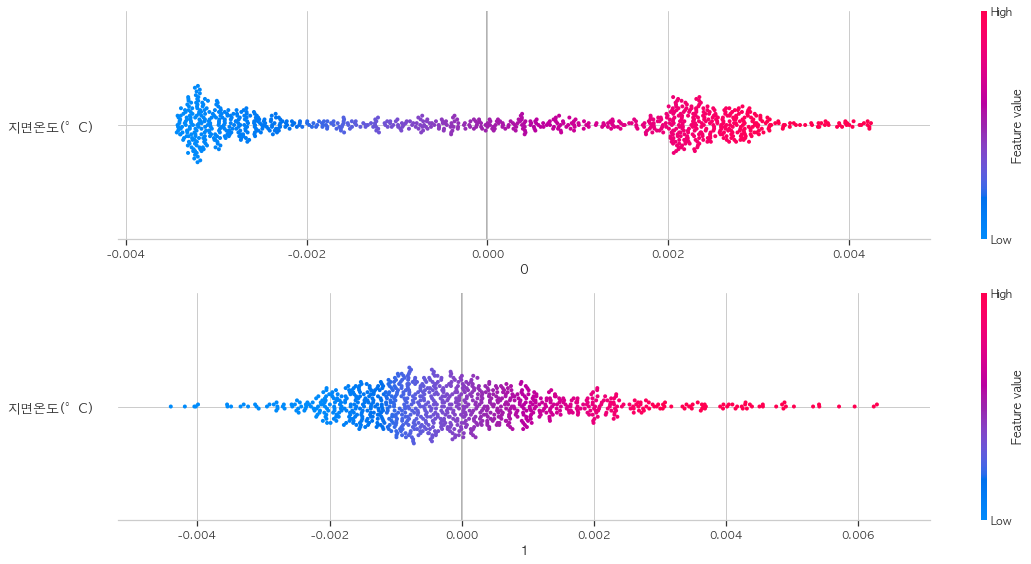

[array([[ 2.13309476e-03],
        [ 2.26111281e-03],
        [ 2.11886655e-03],
        [ 2.10071516e-03],
        [ 2.18158332e-03],
        [ 2.08869064e-03],
        [ 2.09034391e-03],
        [ 2.27750633e-03],
        [ 2.08392000e-03],
        [-1.50248772e-04],
        [ 2.01841054e-03],
        [ 2.39479018e-03],
        [ 2.32508552e-03],
        [ 1.40533089e-03],
        [ 2.22237052e-03],
        [ 2.05377430e-03],
        [ 2.17562627e-03],
        [ 2.21911786e-03],
        [ 2.05536452e-03],
        [ 2.23238013e-03],
        [ 2.38117427e-03],
        [ 1.47722357e-03],
        [ 2.29775299e-03],
        [ 2.47174165e-03],
        [ 2.60286426e-03],
        [ 2.71717082e-03],
        [ 2.68732721e-03],
        [ 2.80662624e-03],
        [-3.30954669e-03],
        [ 2.34685933e-03],
        [ 2.55246875e-03],
        [ 1.28530586e-03],
        [ 2.61608764e-03],
        [-1.07678355e-03],
        [ 4.85072102e-04],
        [ 2.46551324e-03],
        [ 1.97612918e-04],
 

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(100,20*len(shap_values_list)))
gs = fig.add_gridspec( len(shap_values_list),1)

for i in range(len(shap_values_list)):
    all_df = pd.DataFrame(shap_values_list[i], columns=Features)
    TEST_EXP = shap.Explanation(
        values = all_df.values, 
        base_values=expected_value_list[i],
        feature_names=Features,
        data = all_df.values)
    
    ax = fig.add_subplot(gs[i, 0])
    shap.plots.beeswarm(TEST_EXP,show=False,plot_size=(16,8))
    ax.set_xlabel(str(i))

plt.tight_layout()
plt.savefig(MODEL_PATH+'/Models_beeswarm.png')
plt.show()

shap_values_list

In [21]:
shap.initjs()
#shap.force_plot(explainer.expected_value.mean(), SH_NP, Features)

In [22]:

sum_1 = np.mean(shap_values[0],axis=1)

In [23]:
shap.force_plot(expected_value_list[0], shap_values_list[0], Features,matplotlib=False)

In [24]:
shap.force_plot(expected_value_list[0], shap_values_list[0][:100], Features,matplotlib=False)

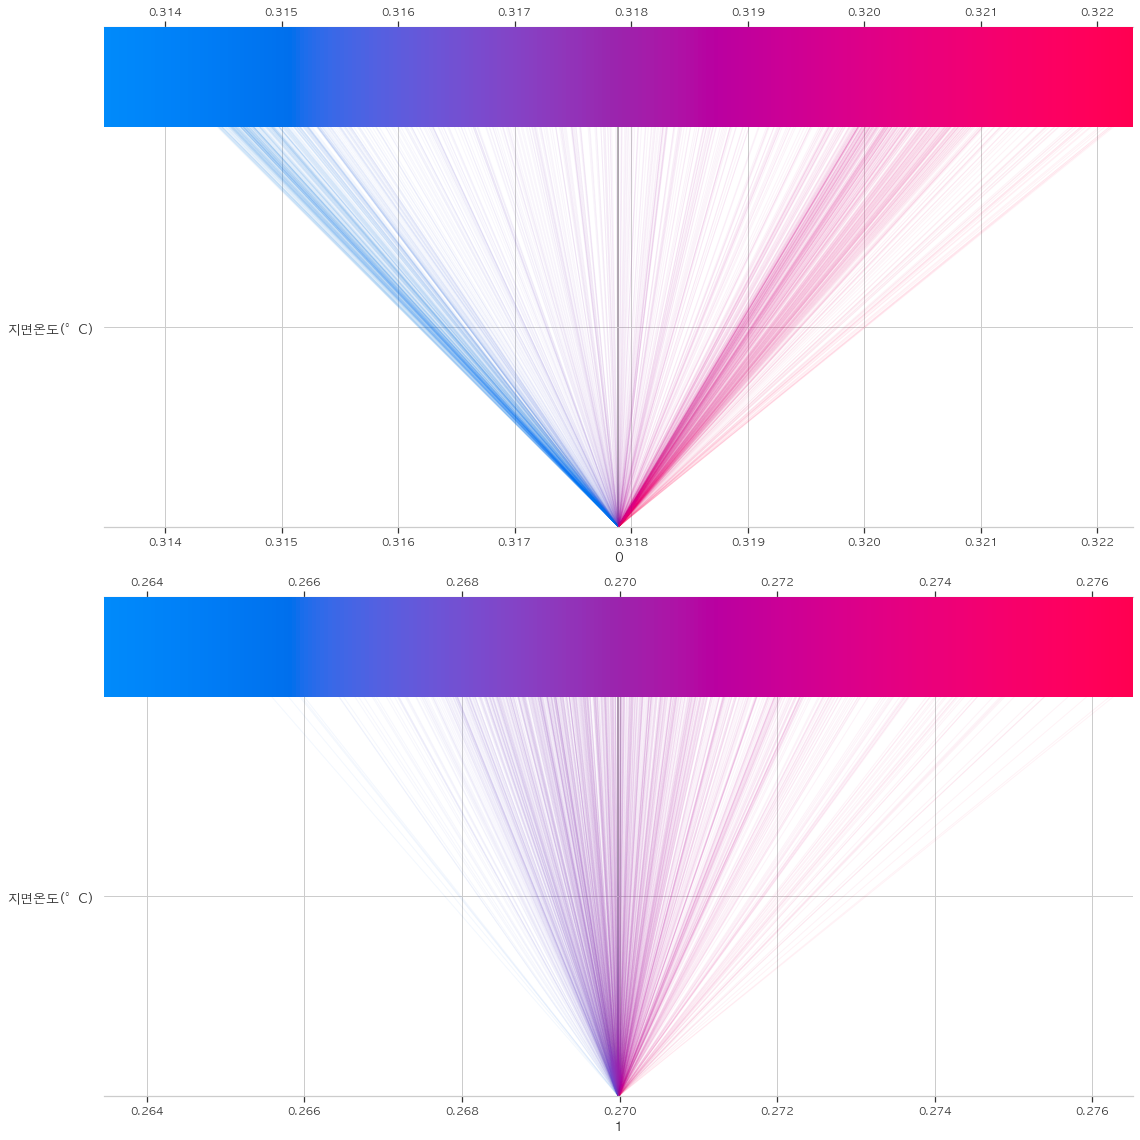

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16,8*len(shap_values_list)))
gs = fig.add_gridspec(len(shap_values_list), 1)

for i in range(len(shap_values_list)):
    all_df = pd.DataFrame(shap_values_list[i], columns=Features).values
    ax = fig.add_subplot(gs[i, 0])
    #all_df = all_df.reshape((24,int(all_df.shape[0]/24/24),24,len(Features)))

    #all_df= all_df.reshape((all_df.shape[0]*all_df.shape[1],all_df.shape[2]))
    shap.decision_plot(expected_value_list[i], all_df, all_df, feature_names=Features, ignore_warnings=True,auto_size_plot=False,show=False,alpha=0.05)
    ax.set_xlabel(str(i))

plt.tight_layout()
plt.savefig(MODEL_PATH+'/Models_decision.png')
plt.show()

In [26]:
COLORS = ['#5567ED', '#ED6D73', '#CE6EEB', '#EDC43E', '#4AED72']
reversed(COLORS)
def renderICE(_Model,_X_DATA,check_col, C_list, ax):
    for _M in range(len(_Model)):
        ICE_d = pd.DataFrame(np.empty((_X_DATA[_M].shape[0], len(C_list))), columns = C_list)
        C_train = pd.DataFrame(_X_DATA[_M].reshape((_X_DATA[_M].shape[0]*24,len(Features))),columns=Features).copy()
        for C in C_list:
            C_train[Features[check_col]] = C
            values = C_train.values
            values = values.reshape((int(C_train.shape[0]/24),24,len(Features)))
        
            y_hat = _Model[_M].predict(values)
            #y_hat = y_hat.mean(axis=1)
            
            y_hat = y_hat.flatten()
        
            ICE_d[C] = list(y_hat)
            
        for i in range(_X_DATA[_M].shape[0]):
        #for i in range(_X_DATA[_M].shape[0]):
            ax.plot(ICE_d.T.index, ICE_d.T[i], color = COLORS[_M], linewidth = 0.2 , alpha=0.3)
        ND = np.array(ICE_d)
    
        ND = np.average(ND,axis=0)
        ax.plot(ICE_d.T.index, ND, color = 'black', linewidth = 3.0)
        ax.plot(ICE_d.T.index, ND, color = COLORS[_M], linewidth = 2.0)
        print(ICE_d.size)
        ICE_d.to_csv(MODEL_PATH+'/'+MODEL_NAME+'_'+str(_M)+'_ICE_'+str(check_col)+'.csv')

    print('ICE값 저장')
    ax.set_title(Features[check_col])

10252
10890
ICE값 저장


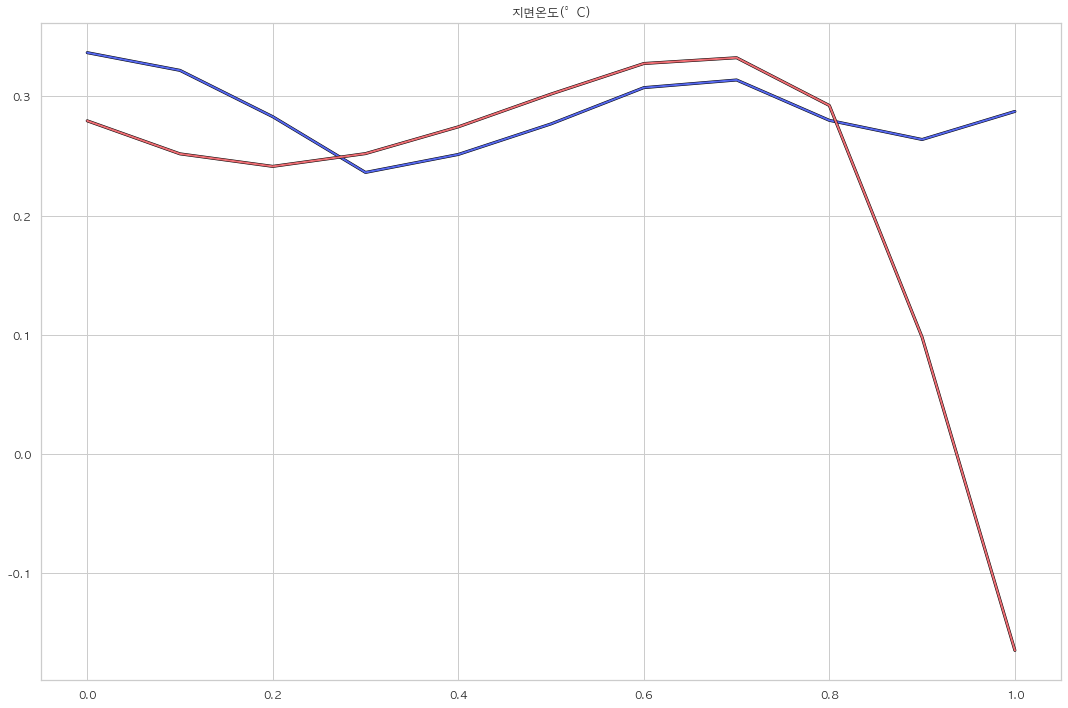

In [27]:
import json
fig = plt.figure(figsize=(15, 10))
C_list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
#C_list = [0,1.0]
for i in range(len(Features)):
    renderICE(ENS_MODELS,G_TRAIN_X, i, C_list, fig.add_subplot(1, len(Features), i+1))
plt.tight_layout()
plt.savefig(MODEL_PATH+'/Models_ICE.png')
plt.show()